# Screen Time Atlas

![Screen Time Atlas](assets/screentimeatlas-2.jpg)

## Introduction

This exercise was part of [Fixing Social Media](https://www.umass.edu/spp/fixing-social-media-0), a graduate class at UMass Amherst.

### Objective

The prompt was: 

>*For the next week, maintain a diary of all the media you encounter - news, entertainment, etc. Pay attention in particular to how you came into contact with a piece of media - did >you choose to read it, discover it via social media, have it recommended to you? What parts of your media diet are algorithmically driven? Do you understand why you’re encountering >certain content? How are you encountering information through different mediums and how do you feel about the encounters?*
>
>*After collecting data for at least one week, produce a visualization of your media consumption. Please feel free to color outside the lines for this - no Excel charts. Students have >used everything from watercolors, Instagram video stories to interpretive dance to visualize their media consumption.*

### Approach

I spent a long time thinking of how to visualize my digital life. At first, I intended to record my location with GPS for 24 to 48 hours: I was planning to export the .gpx files and 'play' the tracks back with an additional visualization of which services and web pages I was using. 

The visualization seemed doable with Blender's BLOSM plugin which allows import from .gpx and OpenStreetMap data. Here is an example of my 'orb' (i.e. a representation of my location) commuting from Northampton to Amherst (can you recognize the Connecticut River?):

![A simple commute example - Blender](assets\Code_zi2ulkr5hC.gif)

Much of the code in this repository has to do with that approach, which I eventually decided not to take for these reasons:

1. iOS browser history export is more challenging to export than I estimated. The files are saved in a SQLite database on Macs, but I could not extract phone/tablet history as easily.
2. When I exported sample browsing history and adapted it to UTC timezones, it was challenging to 'replay' the time-series data in a presentable way that would sync with the .gpx tracks.
4. Finally, there was no straightforward way of using .gpx timestamps as an F-curve inside Blender: I would have to manually orchestrate the moving of my 'dot', which for me lessened the impact of the presentation.

I took a long detour trying to learn Adobe After-Effects as a way of playing my browsing history, but it was stalling. 

So I took a new approach: maps!

#### Mapping imaginary continents

The idea of 'Screen Time Atlas' is that each continent represents a category defined by [Apple Screen Time](https://support.apple.com/en-us/108806#:~:text=To%20see%20the%20report%2C%20go,up%20or%20received%20a%20notification.).

Roughly speaking, my workflow was to:

1. Transcribe the results of Apple Screentime into a rediculously simple spreadsheet.
2. Multiply by 50 to estimate how many kilometers they would equal to, i.e.:

| Category              | Time Spent | Kilometers (Time*50) |
|-----------------------|------------|----------------------|
| Information & Reading | 5.3        | 265                  |
| Social                | 6.5        | 325                  |
| Other                 | 1.3        | 65                   |
| Entertainment         | 3.4        | 170                  |
| Productivity & Finance| 5.2        | 260                  |
| Creativity            | 0.2        | 10                   |
| Shopping & Food       | 0.2        | 10                   |
| Travel                | 0.1        | 5                    |

**The code below was generated by OpenAI ChatGPT and tuned accordingly by me.** In-code comments are a mix of ChatGPT output and my own commentary.

To be clear, I do not have a background in programming or game design, so the method I selected here was a result of trial-and-error. ChatGPT's original suggestion of using Perlin noise to generate landmasses did not create cohesive continents, but using a 'random walk' algorithm did come up with attractive results.

It looks like the code for the random walk may have been adapted from [here](https://stackoverflow.com/questions/71681417/generating-a-1d-random-walk-with-random-module) or [here](https://www.geeksforgeeks.org/random-walk-implementation-python/).

That all said, I have tested the code and believe it works as intended.

In [839]:
size = (200, 200)  # This stays constant for scale
steps = 9000  # Steps for random walk; this decides how big the continent becomes. Default 5000 for large continents.
resolution = 100000  # Assume each pixel represents n meters. Made up anyways, but a frame of reference.

Area of the landmass: 302.5 square kilometers


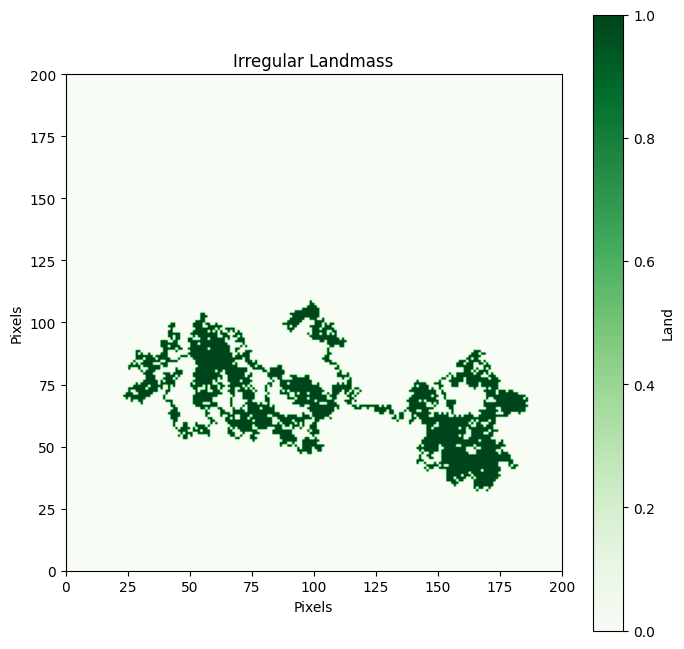

Landmass exported to: landmass.tif


In [842]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin

# Function to generate a landmass using random walk algorithm
def generate_landmass(size, steps):
    # Initialize variables
    landmass = np.zeros(size)
    x, y = size[0] // 2, size[1] // 2  # Start from the center
    for _ in range(steps):
        # Randomly select a direction
        dx, dy = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
        # Move the particle
        x, y = np.clip(x + dx, 0, size[0] - 1), np.clip(y + dy, 0, size[1] - 1)
        # Mark the current position as land
        landmass[x, y] = 1
    return landmass

# Function to calculate the area of the landmass in square kilometers
def calculate_landmass_area(landmass, resolution):
    # Count the number of land pixels
    land_pixels = np.count_nonzero(landmass)
    # Calculate the area in square kilometers
    area_sq_km = land_pixels * resolution / 1000000
    return area_sq_km

# Generate the landmass
landmass = generate_landmass(size, steps)

# Calculate the area of the landmass
area_sq_km = calculate_landmass_area(landmass, resolution)
print("Area of the landmass:", area_sq_km, "square kilometers")

# Plot the landmass
plt.figure(figsize=(8, 8))
plt.imshow(landmass, cmap='Greens', origin='lower', extent=[0, size[1], 0, size[0]])
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Irregular Landmass')
plt.colorbar(label='Land')
plt.show()

# Define the geographic extent of the landmass
xmin, ymin = 0, 0  # Adjust as needed
xmax, ymax = xmin + size[1] * resolution, ymin + size[0] * resolution

# Define the transformation matrix
transform = from_origin(xmin, ymax, resolution, resolution)

# Specify the output file path
output_path = "landmass.tif"  # Adjust the file name as needed

# Write the landmass to a GeoTIFF file
# GeoTIFF coordinates were not used in the final product, as I ended up using Illustrator instead of ArcGIS, therefore no coordinate system was necessary. But having a GeoTIFF did not hurt.
with rasterio.open(output_path, 'w', driver='GTiff', height=size[0], width=size[1], count=1, dtype=np.uint8, crs='EPSG:4326', transform=transform) as dst:
    dst.write(landmass * 255, 1)  # Multiply by 255 to convert to 8-bit representation

print("Landmass exported to:", output_path)


#### Choosing landmasses

My 'continents' were chosen only if they did not exceed the 200x200 grid. This was based on aesthetic criteria but also because I was not sure if their pixels - and therefore their area - would still be measured if they were out of bounds.

Iterating through different examples looked like this:

![Flipping through map options](assets/flipping_through.gif)

Size was modulated with the `steps` option. I found one that looked like a continent and matched for each of the Apple Screen Time categories. That resulted in a spreadsheet like this:

| Category              | Time Spent | Kilometers (Time*50) | Steps Taken | TIFF output                               | TIFF filepath                                      |
|-----------------------|------------|----------------------|-------------|--------------------------------------------|----------------------------------------------------|
| Information & Reading | 5.3        | 265                  | 8100        | Area of the landmass: 265.1 square kilometers | \fixingsocialmedia\final_landmasses\landmass_information_reading.tif |
| Social                | 6.5        | 325                  | 9000        | Area of the landmass: 335.2 square kilometers | \fixingsocialmedia\final_landmasses\landmass_social.tif              |
| Other                 | 1.3        | 65                   | 1800        | Area of the landmass: 65.8 square kilometers  | \fixingsocialmedia\final_landmasses\landmass_other.tif               |
| Entertainment         | 3.4        | 170                  | 5000        | Area of the landmass: 172.6 square kilometers | \fixingsocialmedia\final_landmasses\landmass_entertainment.tif       |
| Productivity & Finance| 5.2        | 260                  | 8100        | Area of the landmass: 263.2 square kilometers | \fixingsocialmedia\final_landmasses\landmass_productivity_finance.tif|
| Creativity            | 0.2        | 10                   | 300         | Area of the landmass: 10.9 square kilometers | \fixingsocialmedia\final_landmasses\landmass_creativity.tif         |
| Shopping & Food       | 0.2        | 10                   | 100         | Area of the landmass: 10.1 square kilometers | \fixingsocialmedia\final_landmasses\landmass_shopping_food.tif      |
| Travel                | 0.1        | 5                    | 100         | Area of the landmass: 5.3 square kilometers  | \fixingsocialmedia\final_landmasses\landmass_travel.tif             |

### Adobe Illustrator

After that I imported each into Illustrator being careful to retain a common scale:

![TIFF imports](assets/tiff_imports.gif)

#### Tracing (TIFF to vector graphics)

Adobe has a neat feature called Image Trace. That allows this:

![Before Trace](assets/tiff_before_trace.png)

To become this:

![After Trace](assets/tiff_after_trace.png)

Everything after that was done intuitively. I re-positioned and re-colored (although I did *not* re-scale) the continents in an attractive arrangement. Then, I returned to the Screen Time app and expanded the categories, e.g. reflecting that Reddit consumed a largest portion of my time spent in that category.

Following that, I wrote a brief description in poster-board form in InDesign, then applied paper-like texture in Photoshop. The final step was to light the scene diffusely in Blender, then adjust exposure in Lightroom. Overkill? Probably! But since this map was never going to be printed out, I thought it would be a shame if it didn't look like it had 'real' texture.

### What did I find?
Leafing through my browsing history and app usage gave me a distinct impression: *I am distracted easily*. I am also surprised at how much time I spend between Facebook, Instagram, and Threads – all owned and operated by Meta Platforms Inc. Indeed, the body of water I called the ‘gulf of attention’ is probably characterized most by ‘reels’: Instagram, YouTube, and Threads. While I was arranging the map, I didn’t even do that on purpose.

The prompt for this exercise posed, “what parts of your media diet are algorithmically driven?”. Well, isn’t all of it? On the map, look how prominent Google News and Google Search are: those aren’t neutral, non-cultivated sources of information. Google News knows I am a doomscrolling millennial obsessed with the latest developments in the housing crisis (and emphatically not interested in the Wall Street Journal). Google Search knows me well enough to recommend medications through AdSense.

The few sites on this map where content was not algorithmically determined – NYT and perhaps my work’s ticketing system – are arguably ‘algorithmic’ in their own way. Consider the New York Times – what is their editorial board if not algorithmic? Since the late 19th century, the front page of the print edition has literally been a ‘ranking’ of content based on what the editors believed was the most compelling, captivating information for their target audience. I have self-selected into that audience. What could you call that? A macro-algorithm? 

Looking at the perimeter of my map begs the question – what is the blue space, the ocean, for? Does it represent free, interstitial time? Nothing? Or everything else?

### Acknowledgements

As I noted above, I did use ChatGPT to generate code and in-code comments for the continent-creator tool. ChatGPT also assisted me with navigating Illustrator context menus, but I did not use any Adobe generative tools as part of the assignment.

Aside from that, all work and ideas are mine.

In Adobe Illustrator, I used a single pattern from ['Treasure Map Assets' by Spoon Graphics](https://blog.spoongraphics.co.uk/freebies/download-free-treasure-map-maker-adobe-illustrator), which the artist has graciously provided free.

This is the pattern:

![Pattern](assets/treasure.png)

UPDATE:

As it turns out, I owe credit to xkcd for creating a map that presumably burned itself into my consciousness when it came out nearly 15 years ago:
[xkcd: Online Communities 2](https://xkcd.com/802_large/)
My artistic contribution is meager in comparison, but then again, my map is completely tailored to me. Also note that Twitter – which I used heavily as a high school sophomore in 2010 – is completely absent from my map. Thanks Prof. Z for pointing out these maps’ existence!
